# Download of Libraries and Data

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import json 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from keras.applications.inception_v3 import preprocess_input 

# Set the seed for random operations in order to let the experiment be reproducible
SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

In [ ]:
# Cell necessary when working on Colab with Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell in which it unzips given the directory
!unzip '/content/drive/My Drive/DeepLearning/kaggle/data/artificial-neural-networks-and-deep-learning-2020.zip'

Output streaming troncato alle ultime 5000 righe.
  inflating: MaskDataset/training/10891.jpg  
  inflating: MaskDataset/training/10892.jpg  
  inflating: MaskDataset/training/10894.jpg  
  inflating: MaskDataset/training/10899.jpg  
  inflating: MaskDataset/training/10901.jpg  
  inflating: MaskDataset/training/10902.jpg  
  inflating: MaskDataset/training/10905.jpg  
  inflating: MaskDataset/training/10906.jpg  
  inflating: MaskDataset/training/10907.jpg  
  inflating: MaskDataset/training/10908.jpg  
  inflating: MaskDataset/training/10911.jpg  
  inflating: MaskDataset/training/10913.jpg  
  inflating: MaskDataset/training/10915.jpg  
  inflating: MaskDataset/training/10916.jpg  
  inflating: MaskDataset/training/10917.jpg  
  inflating: MaskDataset/training/10919.jpg  
  inflating: MaskDataset/training/10920.jpg  
  inflating: MaskDataset/training/10921.jpg  
  inflating: MaskDataset/training/10922.jpg  
  inflating: MaskDataset/training/10923.jpg  
  inflating: MaskDataset/train

# Processing of Dataset and creation of Generators

In [ ]:
#Directories repectively for the json file and data for the training 
labels_dir = os.path.join(cwd, 'MaskDataset')
training_dir = os.path.join(cwd, 'MaskDataset/training')

#Sizes chosen for the batches and images' height and width
bs = 8
img_h = img_w = 512

#In order to associate the labels in the json file to the images of the training set we used a panda dataFrame
with open(os.path.join(labels_dir, "train_gt.json")) as f:
  dic = json.load(f)
labels = pd.DataFrame(dic.items())
labels.rename(columns = {0:'filename', 1:'class'}, inplace = True)
labels["class"] = labels["class"].astype(str)

#Here we split the data set in two parts, 80% will be used for training and 20% for validation 
tl, vl = train_test_split(labels, test_size=0.20, random_state=SEED)

#Create training ImageDataGenerator object in order to successively apply Data Augmentation 
apply_data_augmentation = True

if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10, #other values we tried were 20 and 30 but caused no significant change
                                        width_shift_range=5, 
                                        height_shift_range=5, 
                                        brightness_range=(0.6,1),
                                        channel_shift_range=150,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='nearest',
                                        #rescale=1./255, 
                                        preprocessing_function =tf.keras.applications.inception_v3.preprocess_input)
else :   
    train_data_gen = ImageDataGenerator(rescale=1./255)

# Create validation ImageDataGenerator objects
valid_gen = ImageDataGenerator(preprocessing_function =tf.keras.applications.inception_v3.preprocess_input) 

In [ ]:
from collections import Counter
#Training
train_generator = train_data_gen.flow_from_dataframe(tl,
                                               training_dir,
                                               batch_size=bs,
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED,
                                               target_size=(img_h, img_w)
                                               )

#Here the class weights are computed in order to balance loss during training
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

#Validation
valid_generator = valid_gen.flow_from_dataframe(vl,training_dir,batch_size=bs, 
                                               class_mode='categorical',
                                               color_mode='rgb',
                                               shuffle=False,
                                               seed=SEED,
                                               target_size=(img_h, img_w)
                                               )


Found 4491 validated image filenames belonging to 3 classes.
Found 1123 validated image filenames belonging to 3 classes.


In [ ]:
# Create Dataset objects from the generators
num_classes = 3


#TRAIN
train_dataset = tf.data.Dataset.from_generator(lambda: train_generator,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes])
                                               )
train_dataset = train_dataset.repeat()

#VALID
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_generator,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes])
                                               )
valid_dataset = valid_dataset.repeat()

# It would have been useful to cross-validate in order to 
# tune hyperparameters and make the model see all the validation data


# Transfer Learning

In [ ]:
# Load Model
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input

#Other famous models we have tried 

#vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

#vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

# InceptionV3
inception = tf.keras.applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(img_h, img_w,3))

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
# freeze layers in Inception
count = 1
for layer in inception.layers:
    if count < 50: #by experimenting we found this value to be the best(instead for VGG16 and VGG19 the best value was 15)
        layer.trainable = False
    else:
        layer.trainable = True
    count = count + 1

In [ ]:
#THIS WAS THE ARCHITECTURE WE USED FOR THE REALIZATION OF THE SIMPLE CNN MODEL
#
# Architecture: Features extraction -> Classifier

#from keras.layers import LeakyReLU
#from keras.preprocessing import image
#from keras.applications.mobilenet import preprocess_input

#start_f = 8
#depth = 5

#model = tf.keras.models.Sequential()

# Features extraction
#for i in range(depth):

#    if i == 0:
#        input_shape = [img_h, img_w, 3]
#    else:
#      input_shape=[None]

    # Conv block: Conv2D -> Activation -> Pooling
   
    #model.add(tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3),strides=(1, 1),padding='same', input_shape=input_shape))
    #model.add(tf.keras.layers.ReLU())
    #model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    #start_f *= 2
    
# Classifier
#model.add(tf.keras.layers.ReLU())
#model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dense(units=512, activation='relu'))
#model.add(tf.keras.layers.Dense(units=512, activation='relu'))
#lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.01)
#model.add(tf.keras.layers.Dense(512, activation=lrelu))
#model.add(tf.keras.layers.Dense(512, activation=lrelu))
#model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

In [ ]:
#Instead of using the ReLU as activation function we decided to apply the Leaky ReLU
from keras.layers import LeakyReLU
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.01)

model = tf.keras.models.Sequential()
model.add(inception)
model.add(tf.keras.layers.GlobalAveragePooling2D()) 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation=lrelu))
model.add(tf.keras.layers.Dense(512, activation=lrelu)) 
model.add(tf.keras.layers.Dense(512, activation=lrelu))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Visualize created model as a table
model.summary()

# Visualize initialized weights
#model.weights

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 14, 14, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2

# Training of the model and Tensorboard section

In [ ]:
# Optimization params

# Loss
loss = tf.keras.losses.CategoricalCrossentropy() #standard choice

# learning rate
lr = 2e-5 #a large number of values were tried and with trial and error this was the best value which makes the training quick and limits the oscillations

optimizer = tf.keras.optimizers.Adam(learning_rate=lr) #standard choice

# Validation metrics
metrics = ['accuracy']

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
#This cell and the next one were used to visualize the performance of our attempts
#on tensorboard, in order to use them it is necessary to change the directories

'''
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir /content/drive/My\ Drive/DeepLearning/kaggle/tensorboard 
'''


'\n#%load_ext tensorboard\n%reload_ext tensorboard\n%tensorboard --logdir /content/drive/My\\ Drive/DeepLearning/kaggle/tensorboard \n'

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

callbacks = []

'''
exps_dir = os.path.join('/content/drive/My Drive/DeepLearning/kaggle', 'tensorboard')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'Inception'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)
'''

#Early stopping was applied and also a LR adapter callback,
# which helps us to get into the right minimum. 
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
    callbacks.append(es_callback)
    
#LRPlateau
lr_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=0,
)    

callbacks.append(lr_plateau_callback)    

"\nexps_dir = os.path.join('/content/drive/My Drive/DeepLearning/kaggle', 'tensorboard')\nif not os.path.exists(exps_dir):\n    os.makedirs(exps_dir)\n\nnow = datetime.now().strftime('%b%d_%H-%M-%S')\n\nmodel_name = 'Inception'\n\nexp_dir = os.path.join(exps_dir, model_name + '_' + str(now))\nif not os.path.exists(exp_dir):\n    os.makedirs(exp_dir)\n\n# Model checkpoint\n# ----------------\nckpt_dir = os.path.join(exp_dir, 'ckpts')\nif not os.path.exists(ckpt_dir):\n    os.makedirs(ckpt_dir)\n\nckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), \n                                                   save_weights_only=True)  # False to save the model directly\ncallbacks.append(ckpt_callback)\n\n# Visualize Learning on Tensorboard\n# ---------------------------------\ntb_dir = os.path.join(exp_dir, 'tb_logs')\nif not os.path.exists(tb_dir):\n    os.makedirs(tb_dir)\n    \n# By default shows losses and metrics for both training and val

In [ ]:
model.fit(x=train_dataset,
          epochs=30,  #Generally the training stops before this value
          steps_per_epoch=len(train_generator),
          validation_data=valid_dataset,
          validation_steps=len(valid_generator),
          class_weight=class_weights,
          callbacks=callbacks
          )

Epoch 1/30
562/562 [==============================] - 393s 699ms/step - loss: 0.7459 - accuracy: 0.6348 - val_loss: 0.4233 - val_accuracy: 0.8041
Epoch 2/30
562/562 [==============================] - 391s 696ms/step - loss: 0.4500 - accuracy: 0.8092 - val_loss: 0.2522 - val_accuracy: 0.8949
Epoch 3/30
562/562 [==============================] - 393s 699ms/step - loss: 0.3347 - accuracy: 0.8713 - val_loss: 0.2152 - val_accuracy: 0.9083
Epoch 4/30
562/562 [==============================] - 402s 716ms/step - loss: 0.2680 - accuracy: 0.8994 - val_loss: 0.1776 - val_accuracy: 0.9341
Epoch 5/30
562/562 [==============================] - 403s 718ms/step - loss: 0.2336 - accuracy: 0.9158 - val_loss: 0.1796 - val_accuracy: 0.9377
Epoch 6/30
562/562 [==============================] - 403s 718ms/step - loss: 0.2038 - accuracy: 0.9283 - val_loss: 0.1820 - val_accuracy: 0.9332
Epoch 7/30
562/562 [==============================] - 398s 709ms/step - loss: 0.1875 - accuracy: 0.9328 - val_loss: 0.2111 -

# Testing

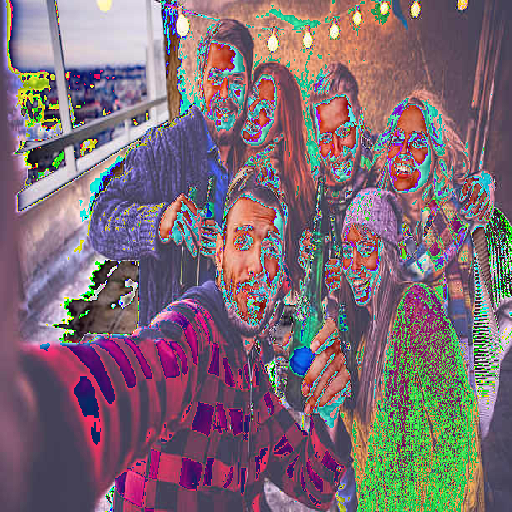

In [ ]:
# Let's visualize the activations of our network
from PIL import Image

test_iter = iter(valid_dataset)

#Get a test image
test_img = next(test_iter)[0]
test_img = test_img[0]

#Visualize the image
Image.fromarray(np.uint8(np.array(test_img)*255.))

In [ ]:
# Function used to create the csv for the submission
def create_csv(results, results_dir='/content/drive/My Drive/DeepLearning'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
#Path of images to test
test_dir = os.path.join(cwd, 'MaskDataset/test')
image_filenames = next(os.walk(test_dir))[2]

results = {}
for image_name in image_filenames:

   img = Image.open(os.path.join(test_dir,image_name)).convert('RGB')

   img = img.resize((512, 512))

   img_array = np.array(img)
 
   img_array = np.expand_dims(img_array, 0) 

   #Compute the prediction for each class
   out_softmax = model.predict(x=img_array / 255.)
  
   #Take the predicted class
   prediction = tf.argmax(out_softmax,1) 

   #print(prediction.numpy()[0])
  
   #The class which was predicted is added to the dictionary which contains images with corresponding label
   results[image_name] = prediction.numpy()[0]

#The function defined in the previous cell is called in order to create the file with final results
create_csv(results)
